<a href="https://colab.research.google.com/github/paulodowd/GoogleColab_Simple2DSimulator/blob/main/Sheet1_2D_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Before you start**, you should have read the worksheet which describes the skills you need and how to operate these following worksheets.  [link]

In this series of exercise sheets we are going to explore using a simple 2D simulator, and then learn how we can improve it.  By following these exercises, we are going to learn about:
- Programming a controller for a simulated wheeled mobile robot.
- The challenges faced when using a real sensor:
  - Simulation & The Reality Gap.
  - Developing a simple model of a Proximity Sensor.
  - Noise & Error.
- Evaluating a more robust controller for a robot.

**To get started**, we first of all need to become familiar with the 2D simulator we are going to use. This exercise sheet has a working 2D simulator embedded within it, and you can review all the code to see how it works.  

**By the end of this worksheet**, you should have written a simple controller so that your simulated robot can drive around for 200 seconds without crashing.  You can compete with your friends to get the highest score.

**In the next worksheet**, we will begin our exercises to improve the simulator, looking specifically at a proximity sensor.  



# About the 2D Simulator

This 2D simulator simulates a robot similar to an **e-puck**:
<table><tr><td>
<p align="center">
<img src="https://static.generation-robots.com/9584-product_cover/e-puck-programmable-robot-with-battery.jpg" width="300">
</p>
</td><td>
<p align="center">
<img src="https://www.researchgate.net/profile/Kevin-Nickels-2/publication/289404595/figure/fig4/AS:499790165311491@1496170670005/Overhead-view-of-an-E-Puck-robot-with-the-angles-between-proximity-sensors-labeled-from.png" width="300">
</p>
</td></tr></table>

The robot can move around on two wheels and it has 8 infra-red proximity sensors to detect obstacles in the environment.  We can program the robot to drive around, turn on the spot, and use it's sensors to avoid colliding with obstacles.  

# Exercise 1

Read through the next section "Code for entities in the 2D Simulator":
- Pay attention to the comments, and see if you can understand what each part represents.  
- At this stage, you do not need to write any code.
- Make sure you click the small play icon '>' at the side of each code block to load it into your browsers memory.  
- At this stage, it is strongly recommended **not to change anything** until you have seen the simulator working properly.

# Code for entities in the 2D Simulator

Below is a very simple model of an obstacle.  We represent an obstacle as a point in 2D space, with a radius.  This means it will appear as a circle.  Looking at the below code, the obstacle will be located in the global coordinate space at x,y, and it will have a radius of 10 by default.  Click '>' to compile before proceeding.

In [12]:
from math import *
import numpy as np

class Obstacle_c:
  x = 0
  y = 0
  radius = 10

  # Assigns itself a random position within
  # the arena, keeping a set distance from
  # the centre
  def __init__(self, arena_size, radius=10):
    rand_ang = np.random.random() * (np.pi*2)
    rand_dist = np.random.uniform(.33, .66) * (arena_size/2)
    self.x = (arena_size/2) + rand_dist*np.cos(rand_ang)
    self.y = (arena_size/2) + rand_dist*np.sin(rand_ang)
    self.radius = radius

The below is a simple model and functions for a proximity sensor.  We will develop this sensor further in the next couple of worksheets.  Click to compile before proceeding.

In [7]:
from math import *
import numpy as np


#
# The model of the proximity sensor.
#
#
class ProxSensor_c:
  
  # current global xy position of sensor
  x = 0
  y = 0
  theta = 0
  
  # To store the last sensor reading
  reading = 0

  # To set sensor local position around the robot body.
  offset_dist = 0
  offset_angl = 0

  # maximum scan range:
  max_range = 20

  # constructor. by default, sensor sits 10 distance forward
  # and faces 0 radians with respect to robot origin (0,0).
  def __init__(self, offset_dist=2, offset_angl=0):
    self.offset_dist = offset_dist
    self.offset_angl = offset_angl


  def updateGlobalPosition(self, robot_x, robot_y, robot_theta ):

    # Current direction of the sensor is the rotation
    # of the robot body plus the fixed rotation of the 
    # sensor around that same body.
    self.theta = self.offset_angl + robot_theta

    # With the rotation, we now work out where the 
    # sensor sits in cartesian space (x,y) by projecting
    # out by offset_distance.
    # Note, we do this as if the sensor was at origin (0,0)
    sensor_x = (self.offset_dist*np.cos(self.theta))
    sensor_y = (self.offset_dist*np.sin(self.theta))

    # commit new position to memory, translating to the 
    # robots current x,y position.
    self.x = sensor_x + robot_x
    self.y = sensor_y + robot_y

    # If we've reset position, the last sensor reading
    # is now wrong.  
    self.reading = -1

  def scanFor( self, obstruction ):

    # See if the obstruction is within the detection
    # range of the sensor.
    distance = np.sqrt( ((obstruction.x - self.x)**2) + ((obstruction.y - self.y)**2) )
    distance = distance - obstruction.radius

    # if out of range, return error
    # note: real sensors aren't this easy.
    if distance > self.max_range:
      return

    # compute this sensors angle toward the obstruction
    # (e.g. where is the object relative to the sensor?)
    a2o = atan2( ( obstruction.y - self.y), (obstruction.x-self.x ))

    # computer the smallest angle between the line of 
    # sight of the sensor, and the current angle to the
    # obstruction.
    # [insert url here]
    angle_between = atan2( sin(self.theta-a2o),  cos(self.theta-a2o) )
    angle_between = abs( angle_between )
    
    # If the detection is outside of the field of view
    # of the sensor, then we return and do nothing else.
    # This will either leave the reading as -1 (invalid)
    # for the next call.  Or leave the reading as the
    # last valid reading (>-1) it had.
    if angle_between > np.pi/8:
      return

    # If the current reading is -1 then that means
    # this is the first valid reading, and we update
    # the sensor.
    if self.reading < 0:
      self.reading = distance

    # If the sensor already has a valid reading (>-1)
    # then we only store the new reading if it is closer.
    # (closer obstructions block the field of view)
    if self.reading > 0:
      if distance < self.reading:
        self.reading = distance





The below is a simple model of a robot, which includes the proximity sensor above.  Click to compile before proceeding.

In [9]:

from math import *
import numpy as np

#
# The model of the robot.
#
#
class Robot_c:
  x = 0
  y = 0
  theta = 0
  radius = 5 # 5cm radius
  wheel_sep = radius*2 # wheel on either side

  controller = Controller_c()

  # This is the body plan of sensors from
  # an e-puck robot!
  sensor_dirs = [0.296706,
                 0.8726646, 
                 1.570796,
                 2.617994, 
                 3.665191, 
                 4.712389,
                 5.410521, 
                 5.986479]

  prox_sensors = [] #= ProxSensor_c()
  for i in range(0,8):
    prox_sensors.append( ProxSensor_c(2, sensor_dirs[i]) )

  # We could do something like, manually add 2 sensors  
  #prox_sensors.append( ProxSensor_c(2, np.pi/8) )
  #prox_sensors.append( ProxSensor_c(2, -np.pi/8) )

  def __init__(self, x=50,y=50,theta=np.pi):
    self.x = x
    self.y = y
    self.theta = theta

  def updatePosition( self, vl, vr ):
    
    # robot matrix, contributions to motion x,y,theta
    r_matrix = [(vl/2)+(vr/2),0, (vr-vl)/self.wheel_sep]

    # kinematic matrix  
    k_matrix = [
                [ np.cos(self.theta),-np.sin(self.theta),0],
                [ np.sin(self.theta), np.cos(self.theta),0],
                [0,0,1] 
               ]

    result_matrix = np.matmul( k_matrix, r_matrix)

    self.x += result_matrix[0]
    self.y += result_matrix[1]
    self.theta -= result_matrix[2]

    #if self.x > 100:
    #  self.x -= 100
    #if self.x < 0:
    #  self.x += 100
    #if self.y > 100:
    #  self.y -= 100
    #if self.y < 0:
    #  self.y += 100
    

    # Once we have updated the robots new global position
    # we should also update the position of its sensor(s)
    for prox_sensor in self.prox_sensors:
      prox_sensor.updateGlobalPosition( self.x, self.y, self.theta )



  # The sensor checks if it is in range to an obstruction,
  # and if yes, calculates the simulated proximity reading.
  # if no, determines and error result.
  def updateSensors(self, obstruction ):

    # for each sensor
    # for each obstruction
      for prox_sensor in self.prox_sensors:
        prox_sensor.scanFor( obstruction ) 
    
    
      

# The Controller

The below function is the "controller" called by the robot.  The **controller** is the part of the robot software which must decide how the robot should act.  

A robot needs **you** to first of all understand the task, and then write some rules, logic, or intelligence in code so the robot will make autonomous decisions.  This is actually very difficult, because we have to imagine all the different circumstances a robot may encounter. 

In this controller, we need to read the proximity sensors, make a decision, and then set the motor power.  The below class is a minimal template.  You can edit this controller to produce more interesting and intelligent behaviour from your robot.  

In [8]:
# Not done yet.

class Controller_c:
  test=0
  def __init__(self):
    self.test=1

  # On every iteration of the simulation, what should
  # your robot do?
  # Sense -> Plan -> Act
  #
  def update(self):
    self.test=2


# The 2D Simulator

The below code is the Simulator itself, which produces an interactive graph as an output.  Note that, when you run this code pane, it will take some time to execute and to produce the result.  The results is displayed at the bottom as an interactive 2D scatter plot.

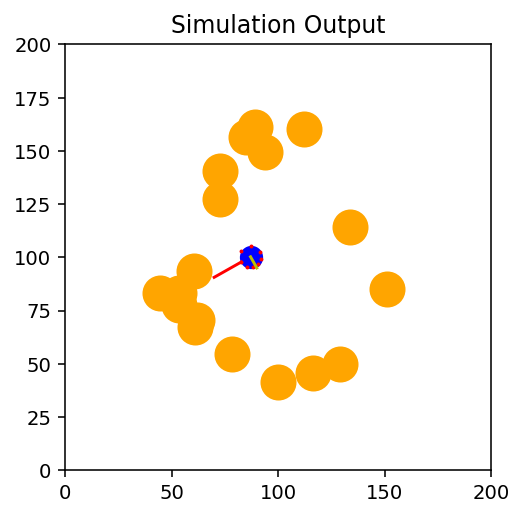

In [10]:
# To produce our animated simulation output
from matplotlib import rc
rc('animation', html='jshtml')

# General libraries
from math import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

arena_width = 200

# An instance of our simulated Robot!
my_robot = Robot_c(arena_width/2,arena_width/2,0)

# An instance of our controller!
my_controller = Controller_c()

# A list of obstacles within the space
obstacles = []
for i in range(18):
  obstacles.append( Obstacle_c(arena_width,8) )

# How many frames (seconds?) of simulation
# Note, a larger value will take longer to execute
# when you press the play button.
numframes = 100

# Create a figure
fig, ax = plt.subplots(dpi=141)

#fig = plt.figure(figsize=(8,8))
# create the plot
#ax = plt.axes()


# This is the main simulator code.  
def simulate( frame_num ):
  
  ax.clear()
  ax.set_xlim(0, arena_width )
  ax.set_ylim(0, arena_width )

  ax.set_aspect(1)
  fig.canvas.draw()
  
  plt.title("Simulation Output")
  
  #print( ax.get_window_extent().width, " ", fig.dpi, " ", draw_scale)

  # Manually settting motor speeds, but this is
  # where we want to call a "controller" function.
  vl = 1 +np.random.normal(0,0.4)
  vr = 0.5 +np.random.normal(0,0.4)
  
  
  my_robot.updatePosition(vl,vr)
  for obstacle in obstacles:
    my_robot.updateSensors( obstacle )

  x = my_robot.x
  y = my_robot.y
  
  
  # Draw the obstacle.
  for obstacle in obstacles:
    scale_by_arena = arena_width / (obstacle.radius*2)
    draw_scale = ((ax.get_window_extent().width  / (scale_by_arena) * 72./fig.dpi) ** 2)
    plot = plt.scatter(obstacle.x,obstacle.y,s=draw_scale, c="orange")

  # Draw where the robot is.
  # Scatter plot markers are not drawn by any unit, quite a
  # strange scale operation:
  # https://stackoverflow.com/questions/48172928/scale-matplotlib-pyplot-axes-scatter-markersize-by-x-scale/48174228#48174228
  scale_by_arena = arena_width / (my_robot.radius*2)
  draw_scale = ((ax.get_window_extent().width  / (scale_by_arena) * 72./fig.dpi) ** 2)  
  plot = plt.scatter(x,y, marker='o',s=draw_scale, c="blue")
  plot = plt.plot( (x,x+my_robot.radius*1.2*np.cos(my_robot.theta)), (y, y+my_robot.radius*1.2*np.sin(my_robot.theta)), 'y-')

  for prox_sensor in my_robot.prox_sensors:
    ox = my_robot.x + (my_robot.radius*cos(prox_sensor.theta))
    oy = my_robot.y + (my_robot.radius*sin(prox_sensor.theta))
    plot = plt.scatter(ox,oy, marker="o",s=1, c="red")
    if prox_sensor.reading > 0:
      tx = prox_sensor.x + prox_sensor.reading * np.cos( prox_sensor.theta)
      ty = prox_sensor.y + prox_sensor.reading * np.sin( prox_sensor.theta)
      plot = plt.plot( (ox,tx), (oy, ty), 'r-')
  
  return plot

# Call the animate function, calling simulate()
anim = animation.FuncAnimation(fig, simulate, numframes, blit=False, repeat=True)
anim

# Exercise 2

Using the above 2D Simulator, ...

[6 7 6 5 3]
[9 5 1 8 7]
655.65
141
1891.206144


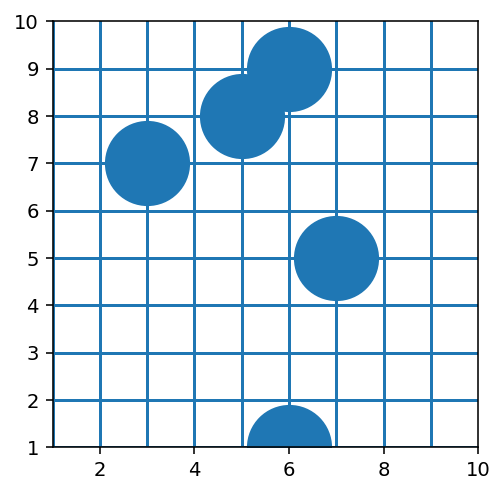

In [18]:
import matplotlib.pyplot as plt
import numpy as np

vmin = 1
vmax = 10

x = np.random.randint(vmin, vmax, 5)
y = np.random.randint(vmin, vmax, 5)
print(x)
print(y)

fig, ax = plt.subplots(dpi=141)
print(ax.get_window_extent().width)
print(fig.dpi)


for v in np.arange(vmin, vmax):
    ax.axvline(v )
    ax.axvline(v)
    ax.axhline(v)
    ax.axhline(v)

ax.set_xlim(vmin, vmax )
ax.set_ylim(vmin, vmax )

ax.set_aspect(1)
fig.canvas.draw()
s = ((ax.get_window_extent().width  / (5) * 72./fig.dpi) ** 2)
print(s)
#vmax-vmin+1.
ax.scatter(x, y, s = s, linewidth=0)

plt.show()